<a id="notations"></a>

# <font color='Red'> Process design of NOx, Gas Absorption Packed Column 
 <font color='Orange'>In the commercial nitric acid plant, the mixture of ammonia with air is passed over catalyst gauze at temperature and pressure in the range of 800-850°C and 0.3 2 MPa, respectively

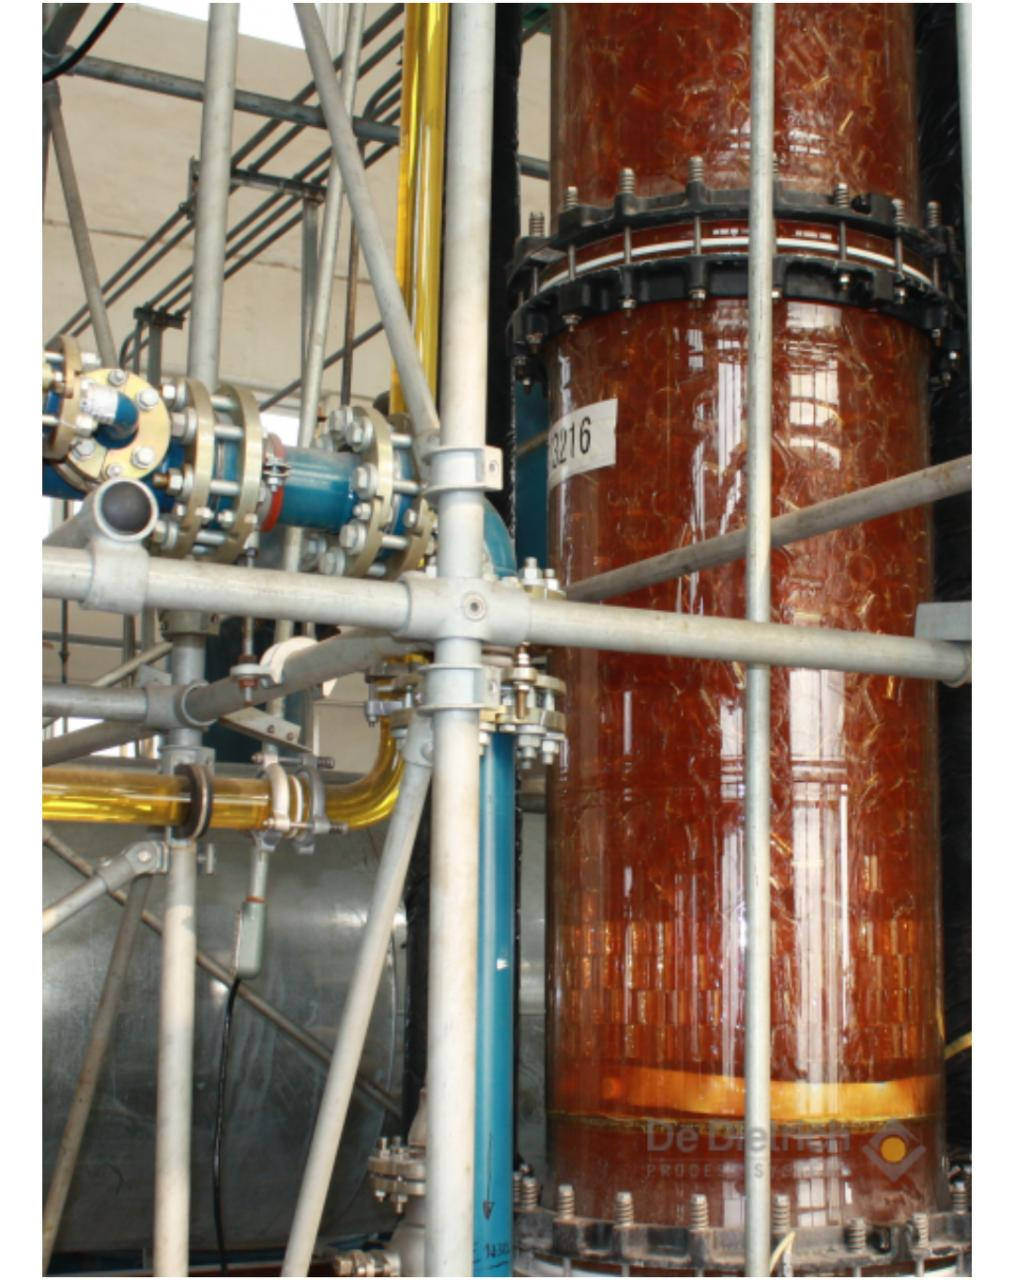

In [170]:
from IPython.display import Image
Image(filename="no2.jpg",width=400,height=400) 

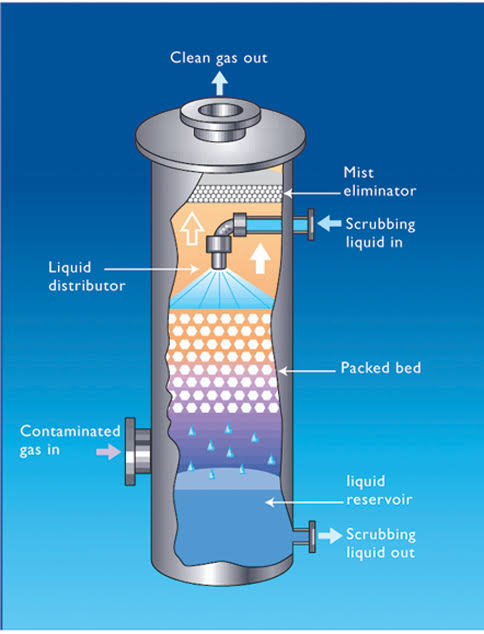

In [171]:
from IPython.display import Image
Image(filename="no1.jpg",width=400,height=400) 

In [172]:
import scipy
import scipy.integrate as scint
import scipy.optimize as scopt
import matplotlib.pyplot as plt
import pandas as pd
from scipy.misc import derivative

<font color='Green'>Consider First Component as Nitric Oxide and Second Component as Oxygen gas coming from the bottom of the tower ,While Water input is from the top

 Mass balance across a differential height dh at height h from the bottom is given as: 
$$
    \frac{dyNO}{ydz}=\frac{kGa*S}{Gs*(1-yNO)^2}*log( \frac{(1-yNO)}{(1-HNO*xNOi)})
$$
And
$$
    \frac{dyO2}{ydz}=\frac{kGa*S}{Gs*(1-yO2)^2}*log( \frac{(1-yO2)}{(1-HO2*xO2i)})
$$


In [173]:
Pressure = 0.3 #MPa
Temperature = 825 
D=0.48 #Diameter 
Gsi=169 #Input Gas Flow Rate in mol/s
yNOin=0.04 #mole fractions
yO2in=0.04 #mole fractions
Gs=(1-y1in-y2in)*Gsi
Ls=240 #input water flow rate in mol/s


In [174]:
rhoG=3.92
gMW=Gs/Gsi*28.81+y1in*28.014+y2in*15.999
Qg=Gsi*gMW*1e-3/1.225
S=scipy.pi*0.25*D**2
Vg=Qg/S
kGa=((0.13 / rhoG) - (0.065/ rhoG ** 2))/10
neuL= 23
kLa=2.6*10**-2
HNO=1.9*10
HO2=1.3*10
H=3

In [175]:
print(kLa,kGa)

0.026000000000000002 0.0028933256976259895


In [176]:
#finding xNOi
def findxNOi(xNO,yNO,xNOi):
    xNOi=(yNO+kLa/kGa*xNO)/(kLa/kGa+HNO)
    return xNOi

In [177]:
#finding xO2i
def findxO2i(xO2,yO2,xO2i):
    xO2i=(yO2+kLa/kGa*xO2)/(kLa/kGa+HO2)
    return xO2i

In [178]:
def model(SV,z,obj):
    [xNO,xO2,yNO,yO2]=SV
    D=obj.D
    S=obj.S
    Ls=obj.Ls
    HNO=obj.HNO
    HO2=obj.HO2
    H=obj.H
    xNOi=0.005
    xO2i=0.005
    dxNObydz=kLa*S/Ls*(1-xNO)**2*scipy.log((1-xNO)/(1-findxNOi(xNO,yNO,xNOi)))
    dxO2bydz=kLa*S/Ls*(1-xO2)**2*scipy.log((1-xO2)/(1-findxO2i(xO2,yO2,xO2i)))
    dyNObydz=kGa*S/Gs*(1-yNO)**2*scipy.log((1-yNO)/(1-HNO*xNOi))
    dyO2bydz=kGa*S/Gs*(1-yO2)**2*scipy.log((1-yO2)/(1-H2*xO2i))
    return [dxNObydz,dxO2bydz,dyNObydz,dyO2bydz]

In [179]:
def get_boundary_residuals(SV0, obj):
    z = scipy.array([0, obj.H])
    trial_solution = scint.odeint(model, SV0, z, args = (obj,))
    SVi = trial_solution[0]
    SVb = trial_solution[-1]
    error = []
    k = 0
    for ic in obj.initial_conditions:
        error.append(ic - SVi[k])
        k = k + 1
    for bc in obj.boundary_conditions:
        error.append(bc - SVb[k])
        k = k +  1
    return error

In [180]:
class absorption:
    def __init__(self):
        self.D=0.48
        self.S=scipy.pi*0.25*D**2
        self.Ls=240
        self.HNO=299
        self.HO2=354
        self.H=3
        self.yNOin=0.04
        self.yO2in=0.04
        self.xNOin=0
        self.xO2in=0
    def solve(self):
        self.x=scipy.linspace(0,self.H,10)
        self.initial_conditions=[self.yNOin,self.yO2in]
        self.boundary_conditions=[self.xNOin,self.xO2in]
        SV0=self.initial_conditions + self.boundary_conditions
        shooting_method_solution = scopt.least_squares(get_boundary_residuals,
                                                      SV0,
                                                      args = (self,))
        SV0=shooting_method_solution.x
        solution = scint.odeint(model, SV0, self.x, args = (self,))
        print(solution)
        self.solution=pd.DataFrame({
            "x":self.x,
            "xNO":solution[:,0],
            "xO2":solution[:,1],
            "yNO":solution[:,2],
            "yO2":solution[:,3],
            
        }
        
        )
    def plotx(self):
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(self.solution["x"], 
                self.solution["xNO"],
                'c', label = "Nitric Oxide")
        ax.plot(self.solution["x"],
               self.solution["xO2"],
               'g', label="Oxygen")
        ax.legend()
        ax.xaxis.label.set_text("Height in m")
        ax.yaxis.label.set_text("mole fraction in liquid")
        ax.title.set_text("Concentration Profiles")
        
    def ploty(self):
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(self.solution["x"], 
                self.solution["yNO"],
                'c', label = "Nitric Oxide")
        ax.plot(self.solution["x"],
               self.solution["yO2"],
               'g', label="Oxygen")
        ax.legend()
        ax.xaxis.label.set_text("Height in m")
        ax.yaxis.label.set_text("mole fraction in gases")
        ax.title.set_text("Concentration Profiles")

In [181]:
# cchex1 is object of absorption
cchex1 = absorption()
cchex1.H = 5

In [182]:
cchex1.solve()

[[ 4.00000000e-02  4.00000000e-02 -1.18399885e-05 -1.13160567e-06]
 [ 3.99997200e-02  3.99997557e-02 -1.05244105e-05 -1.00587064e-06]
 [ 3.99994400e-02  3.99995114e-02 -9.20883846e-06 -8.80135879e-07]
 [ 3.99991600e-02  3.99992672e-02 -7.89327234e-06 -7.54401381e-07]
 [ 3.99988801e-02  3.99990229e-02 -6.57771214e-06 -6.28667151e-07]
 [ 3.99986001e-02  3.99987786e-02 -5.26215787e-06 -5.02933187e-07]
 [ 3.99983201e-02  3.99985343e-02 -3.94660952e-06 -3.77199490e-07]
 [ 3.99980401e-02  3.99982901e-02 -2.63106709e-06 -2.51466060e-07]
 [ 3.99977602e-02  3.99980458e-02 -1.31553058e-06 -1.25732897e-07]
 [ 3.99974802e-02  3.99978015e-02  9.69337729e-16 -3.37031233e-17]]


In [183]:
cchex1.solution

,x,xNO,xO2,yNO,yO2
0,0.000000,0.040000,0.040000,-1.183999e-05,-1.131606e-06
1,0.555556,0.040000,0.040000,-1.052441e-05,-1.005871e-06
2,1.111111,0.039999,0.040000,-9.208838e-06,-8.801359e-07
3,1.666667,0.039999,0.039999,-7.893272e-06,-7.544014e-07
4,2.222222,0.039999,0.039999,-6.577712e-06,-6.286672e-07
5,2.777778,0.039999,0.039999,-5.262158e-06,-5.029332e-07
6,3.333333,0.039998,0.039999,-3.946610e-06,-3.771995e-07
7,3.888889,0.039998,0.039998,-2.631067e-06,-2.514661e-07
8,4.444444,0.039998,0.039998,-1.315531e-06,-1.257329e-07
9,5.000000,0.039997,0.039998,9.693377e-16,-3.370312e-17


(None, None)

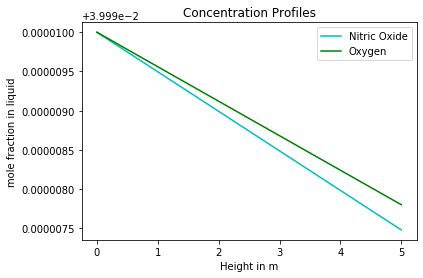

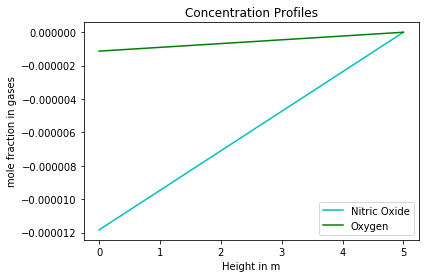

In [184]:
cchex1.plotx() , cchex1.ploty()

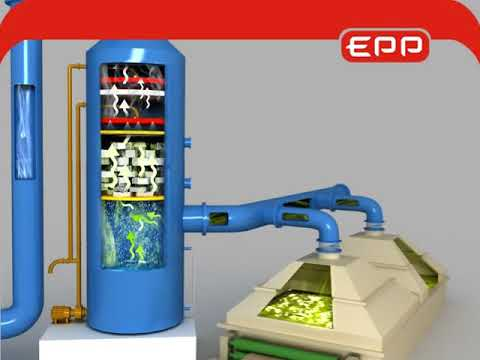

In [185]:
from IPython.display import YouTubeVideo
YouTubeVideo(id='OGxBvaxSzyk',width=500,height=300)

In [189]:
from IPython.display import IFrame
IFrame('170.Multicomponent gas absorption modelling and simulation of NOx absorption in nitric acid manufacture.pdf', width=600, height=300)

### <font color='green'>Prepared by :- Apurva Pawar


<font color='Purple'><font size='6'>THANK YOU

<font color='Brown'>*To Revisit the entire Solution or to move to the top* </font>[Click here](#notations)